In [2]:
import glob
import json
import os
import numpy as np
import cv2
from skimage import img_as_float
from skimage.draw import line,circle
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
from skimage.feature import *
from skimage.color import rgb2grey
from scipy import spatial

np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def draw_rectangle(img, x0, y0, x1, y1, color=(0, 0, 0)):
    draw_line(img, x0, y0, x0, y1, color)
    draw_line(img, x0, y0, x1, y0, color)
    draw_line(img, x1, y0, x1, y1, color)
    draw_line(img, x0, y1, x1, y1, color)


def draw_line(img, x0, y0, x1, y1, color=(0, 0, 0)):
    x0 = min(img.shape[1]-1, max(0, x0))
    y0 = min(img.shape[0]-1, max(0, y0))
    x1 = min(img.shape[1]-1, max(0, x1))
    y1 = min(img.shape[0]-1, max(0, y1))
    yy, xx = line(y0,x0,y1,x1)
    img[yy, xx, :] = color



def draw_bbox(img, label):
    img = np.array(img)
    left_hand, right_hand = [], []
    colors = {'L':(1,0,0),'R':(0,1,0)}
    for htype, box in label['bbox'].items():
        hand = np.array(img[box[1]:box[3], box[0]:box[2]])
        if htype == 'L':
            left_hand.append(hand)
        else:
            right_hand.append(hand)
        draw_rectangle(img, box[0], box[1], box[2], box[3], color=colors[htype])
        draw_rectangle(img, box[0] + 1, box[1] + 1, box[2] + 1, box[3] + 1, color=colors[htype])

    return img, left_hand, right_hand



In [4]:
images, labels = [], []
left_hands, right_hands = [], []
img_paths = sorted(glob.glob("data/DeepQ-Vivepaper/data/book/img/img_*.png" )) + sorted(glob.glob("data/DeepQ-Vivepaper/data/air/img/img_*.png" ))
for img_path in img_paths:
    iid = os.path.basename(img_path).replace(".png","").replace("img_","")
    label_path = img_path.replace("img", "label").replace("png", "json")
    img = imread(img_path)
    label = json.load(open(label_path))
    images.append(img)
    labels.append(label)
    
    _, left_hand, right_hand = draw_bbox(img, label)
    left_hands += left_hand
    right_hands += right_hand

In [4]:
bow_trainer = cv2.BOWKMeansTrainer(128)
sift = cv2.xfeatures2d.SIFT_create()

for img in left_hands + right_hands:
    kp, des = sift.detectAndCompute(img, None)
    bow_trainer.add(des)

print ('\nClustering %d descriptors...' % bow_trainer.descriptorsCount())
voc = bow_trainer.cluster()
np.save('vocabulary.npy', voc)



Clustering 34232 descriptors...


KeyboardInterrupt: 

In [111]:
# initialize
sift = cv2.xfeatures2d.SIFT_create()
extract = sift
flann_params = dict(algorithm=1, trees=5)  # FLANN_INDEX_KDTREE=1
matcher = cv2.FlannBasedMatcher(flann_params, {})
bow_extractor = cv2.BOWImgDescriptorExtractor(extract, matcher)
voc = np.load('vocabulary.npy')
bow_extractor.setVocabulary(voc)

In [142]:
def sift_feature(img):
    f = bow_extractor.compute(img, sift.detect(img))[0]
    return f

In [143]:
def generate_areas(img, shape=(144, 144), stride=20):
    m, n, _ = img.shape
    areas = []
    coors = []
    for i in range(0, m-shape[0], stride):
        for j in range(0, n-shape[1], stride):
            area = img[i:i+shape[0], j:j+shape[1]]
            coor = [j, i, j+shape[1], i+shape[0]]
            areas.append(area)
            coors.append(coor)
    return areas, coors      

def find_hands(img, left_hand, right_hand, shape=(144, 144), stride=20, threshold=0.5, dist=spatial.distance.hamming):
    label = {}
    m, n, _ = img.shape
    areas, coors = generate_areas(img, stride=stride, shape=shape)
    features = [sift_feature(area) for area in areas]
    right_hand_feature = sift_feature(right_hand)
    right_scores = [dist(feature, right_hand_feature) for feature in features]
    ind = np.argsort(-np.array(right_scores))
    right_ind = ind[0]
    for i in range(10):
        print(coors[ind[i]], right_scores[ind[i]])
    if right_scores[right_ind] > threshold:
        label['R'] = coors[right_ind]
        
    left_hand_feature = sift_feature(left_hand)
    left_scores = [dist(feature, left_hand_feature) for feature in features]
    left_ind = np.argsort(left_scores)[-1]
    if left_scores[left_ind] > threshold:
        label['L'] = coors[left_ind]

    return {'bbox': label}

[360, 90, 560, 290] 0.8671875
[210, 30, 410, 230] 0.8671875
[0, 30, 200, 230] 0.8671875
[330, 90, 530, 290] 0.8671875
[0, 60, 200, 260] 0.8671875
[240, 30, 440, 230] 0.859375
[330, 30, 530, 230] 0.859375
[360, 30, 560, 230] 0.859375
[270, 30, 470, 230] 0.8515625
[90, 30, 290, 230] 0.8515625
{'bbox': {'R': [185, 150, 347, 292], 'L': [218, 324, 311, 457]}}
{'bbox': {'R': [360, 90, 560, 290], 'L': [300, 90, 500, 290]}}


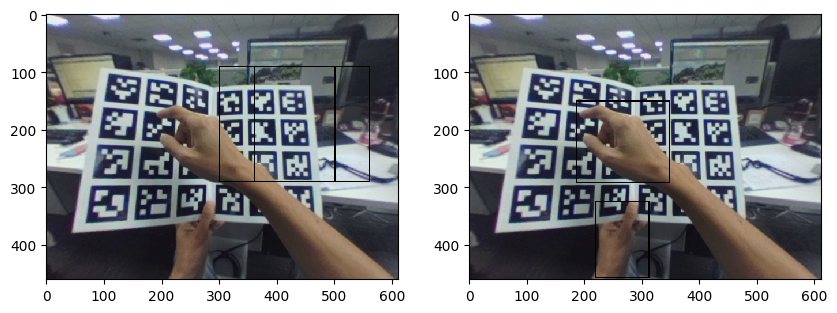

In [151]:
i = 2
label = find_hands(images[i], left_hands[i], right_hands[i], shape=(200, 200), stride=30)
print(labels[i])
print(label)
plt.figure(figsize=(10, 10), dpi=100)
plt.subplot(1,2,1)
bbox, _, _ = draw_bbox(images[i], label)
plt.imshow(bbox)
plt.subplot(1,2,2)
bbox, _, _ = draw_bbox(images[i], labels[i])
plt.imshow(bbox)

In [150]:
choice = np.arange(len(images))
np.random.shuffle(choice)
for i in choice[:10]:
    print(labels[i])
    label = find_hands(images[i], left_hands[0], right_hands[0], threshold=0.2)
    print(label)
    plt.figure(figsize=(10, 10), dpi=100)
    plt.subplot(1,2,1)
    bbox, _, _ = draw_bbox(images[i], label)
    plt.imshow(bbox)
    plt.subplot(1,2,2)
    bbox, _, _ = draw_bbox(images[i], labels[i])
    plt.imshow(bbox)

{'bbox': {'L': [246, 222, 390, 394]}}


KeyboardInterrupt: 

In [5]:
left_hand_des = []
for hand in left_hands:
    kp2, des2 = sift.detectAndCompute(hand, None)
    left_hand_des += list(des2)
right_hand_des = []
for hand in right_hands:
    kp2, des2 = sift.detectAndCompute(hand, None)
    right_hand_des += list(des2)
left_hand_des = np.stack(left_hand_des)
right_hand_des = np.stack(right_hand_des)

In [111]:
img1 = test_images[1]
#img2 = right_hands[6]
kp1, des1 = sift.detectAndCompute(img1,None)
#kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 500)

flann = cv2.FlannBasedMatcher(index_params, search_params)

left_matches = flann.knnMatch(des1, left_hand_des,k=2)
right_matches = flann.knnMatch(des1, right_hand_des,k=2)

# store all the good matches as per Lowe's ratio test.
thre = 0.5
left_good = []
right_good = []
for m,n in left_matches:
    if m.distance < thre*n.distance:
        left_good.append(m)
for m,n in right_matches:
    if m.distance < thre*n.distance:
        right_good.append(m)
print('right:%d, left:%d ' % (len(right_good), len(left_good)))

right:0, left:5 


0
14


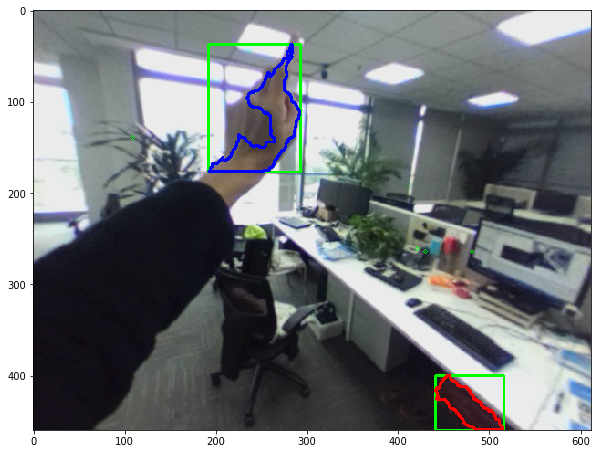

In [112]:
MIN_MATCH_COUNT = 9
left_src_pts = np.float32([ kp1[m.queryIdx].pt for m in left_good ]).reshape(-1,2)
right_src_pts = np.float32([ kp1[m.queryIdx].pt for m in right_good ]).reshape(-1,2)

#     dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

#     M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,500.0)
#     matchesMask = mask.ravel().tolist()

#     h,w, _ = img1.shape
#     pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
#     dst = cv2.perspectiveTransform(pts,M)

#     img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# else:
#     print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
#     matchesMask = None
img3 = np.array(img1)

# Constants for finding range of skin color in YCrCb
min_YCrCb = np.array([0, 87, 134],np.uint8)
max_YCrCb = np.array([255,137,150],np.uint8)
# Find region with skin tone in YCrCb image
imageYCrCb = cv2.cvtColor(img3,cv2.COLOR_BGR2YCR_CB)
skinRegion = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)

# Do contour detection on skin region
_, contours, _ = cv2.findContours(skinRegion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contours):
    area = cv2.contourArea(c)
    if area > 1500:
        print(i)
        color = [(255, 0, 0), (0, 255, 0), (0, 0, 255)][i%3]
        contours[i] = nice_contour(contours[i], 140)
        x,y,w,h = cv2.boundingRect(contours[i])
        cv2.rectangle(img3,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.drawContours(img3, contours, i, color, 2)
        
for pt in left_src_pts:
    img3 = cv2.circle(img3, (pt[0], pt[1]), 2, (0, 255, 0))
for pt in right_src_pts:
    img3 = cv2.circle(img3, (pt[0], pt[1]), 2, (255, 0, 0))

plt.figure(figsize=(10, 10))
plt.imshow(img3)

[(30660, [227, 108, 219, 140]), (13464, [216, 324, 99, 136])]
{'bbox': {'R': [227, 108, 446, 248], 'L': [216, 324, 315, 460]}}
{'bbox': {'R': [219, 108, 393, 265], 'L': [218, 320, 313, 455]}}


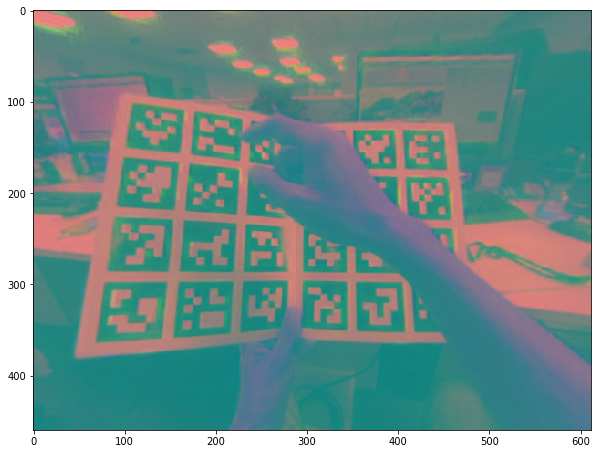

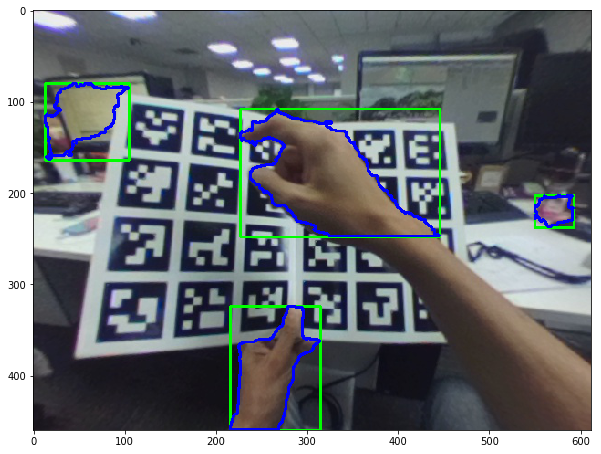

In [5]:
def nice_contour(contour, height=140):
    min_y = min([c[0][1] for c in contour])
    new_contour = [c for c in contour if c[0][1] < min_y + height]
    return np.array(new_contour)

def find_hand_by_color(img, thre_area=1000, color_range=[[ 13,  80, 131], [186, 138, 171]]):
    img = np.array(img)
    # Constants for finding range of skin color in YCrCb
    min_YCrCb = np.array(color_range[0], np.uint8)
    max_YCrCb = np.array(color_range[1], np.uint8)
    # Find region with skin tone in YCrCb image
    imageYCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    plt.imshow(imageYCrCb)
    plt.figure(figsize=(10,10))

    skinRegion = cv2.inRange(imageYCrCb, min_YCrCb, max_YCrCb)

#     lower_thresh = np.array([0, 50, 0], dtype=np.uint8)
#     upper_thresh = np.array([120, 150, 255], dtype=np.uint8)
#     img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#     skinRegion = cv2.inRange(img_hsv, lower_thresh, upper_thresh)
    # Do contour detection on skin region
    _, contours, _ = cv2.findContours(skinRegion, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    candidate_box = []
    for i, c in enumerate(contours):
        area = cv2.contourArea(c)
        if area > thre_area:
            contours[i] = nice_contour(contours[i], 140)
            x,y,w,h = cv2.boundingRect(contours[i])
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
            cv2.drawContours(img, contours, i, (0, 0, 255), 2)
            candidate_box.append((w*h, [x,y,w,h]))
            
    candidate_box = sorted(candidate_box, key=lambda x: -x[0])[:2]
    bbox = {'bbox': {}}
    for _, box in candidate_box:
        coor = [box[0], box[1], box[0]+box[2], box[1]+box[3]]
        if box[0] + box[2] > 0.6 * img.shape[1]:
            bbox['bbox']['R'] = coor
        else:
            bbox['bbox']['L'] = coor
    print(candidate_box)
    print(bbox)
    return bbox, img

i = 0
plt.figure(figsize=(10,10))
plt.imshow(find_hand_by_color(images[i])[1])
print(labels[i])

array([[[122, 109, 167],
        [124, 108, 167],
        [124, 108, 168],
        [125, 108, 168],
        [124, 108, 168],
        [122, 108, 168],
        [119, 108, 168],
        [120, 108, 168],
        [124, 107, 167],
        [126, 107, 167]],

       [[123, 108, 167],
        [124, 108, 167],
        [125, 108, 166],
        [127, 108, 166],
        [124, 108, 167],
        [120, 109, 167],
        [119, 108, 168],
        [119, 108, 168],
        [123, 108, 167],
        [126, 107, 167]],

       [[124, 107, 167],
        [124, 107, 167],
        [128, 108, 165],
        [128, 108, 165],
        [124, 109, 165],
        [120, 109, 166],
        [120, 109, 166],
        [120, 108, 166],
        [124, 108, 165],
        [127, 108, 166]],

       [[124, 108, 167],
        [125, 107, 166],
        [130, 108, 164],
        [128, 108, 164],
        [123, 108, 165],
        [118, 108, 166],
        [119, 109, 166],
        [122, 109, 166],
        [124, 109, 166],
        [126, 109, 

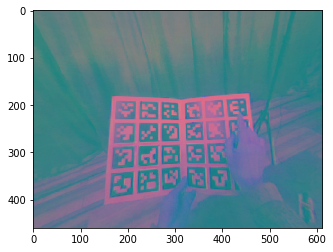

In [225]:
imageYCrCb = cv2.cvtColor(images[i], cv2.COLOR_BGR2YCR_CB)
plt.imshow(imageYCrCb)
imageYCrCb[300:310, 470:480]

[(13860, [318, 32, 99, 140]), (6138, [83, 394, 93, 66])]
{'bbox': {'R': [318, 32, 417, 172], 'L': [83, 394, 176, 460]}}
{'bbox': {'R': [318, 32, 417, 172], 'L': [83, 394, 176, 460]}}
[(13860, [195, 32, 99, 140]), (6138, [436, 394, 93, 66])]
{'bbox': {'L': [195, 32, 294, 172], 'R': [436, 394, 529, 460]}}
{'bbox': {'L': [195, 32, 294, 172], 'R': [436, 394, 529, 460]}}
[(29120, [304, 225, 208, 140]), (7857, [503, 169, 97, 81])]
{'bbox': {'R': [503, 169, 600, 250]}}
{'bbox': {'R': [503, 169, 600, 250]}}
[(20580, [267, 270, 147, 140]), (20300, [41, 195, 145, 140])]
{'bbox': {'R': [267, 270, 414, 410], 'L': [41, 195, 186, 335]}}
{'bbox': {'R': [267, 270, 414, 410], 'L': [41, 195, 186, 335]}}
[(20580, [198, 270, 147, 140]), (20300, [426, 195, 145, 140])]
{'bbox': {'L': [198, 270, 345, 410], 'R': [426, 195, 571, 335]}}
{'bbox': {'L': [198, 270, 345, 410], 'R': [426, 195, 571, 335]}}
[(18340, [304, 272, 131, 140]), (11900, [203, 112, 85, 140])]
{'bbox': {'R': [304, 272, 435, 412], 'L': [203, 11

(0.75, None)

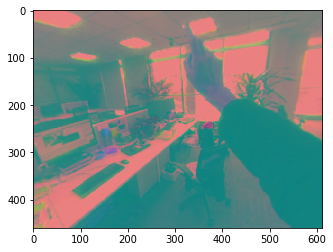

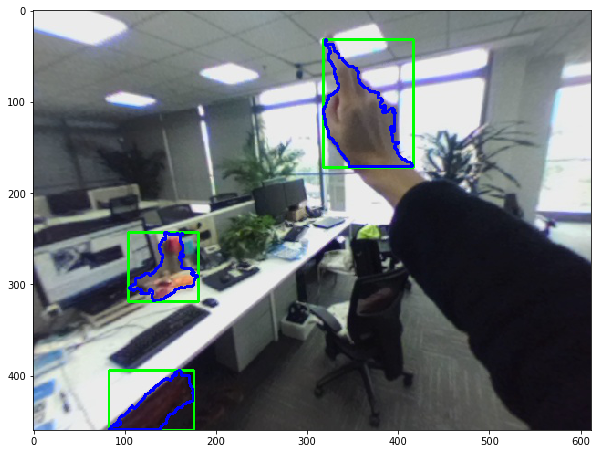

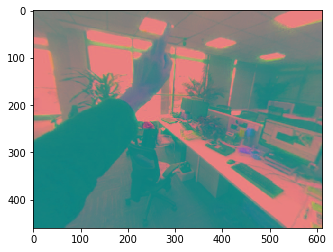

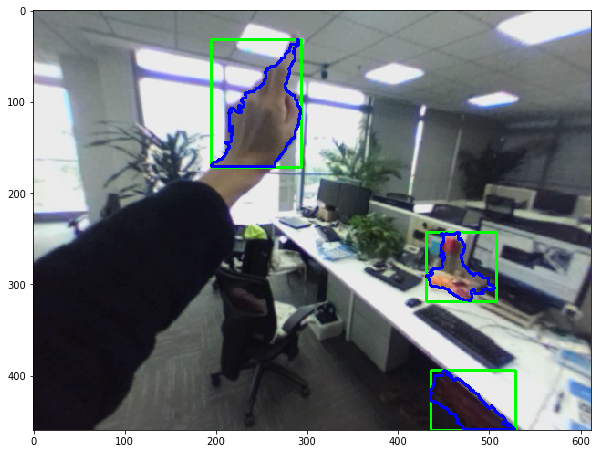

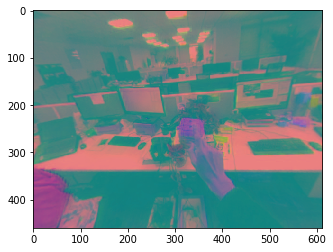

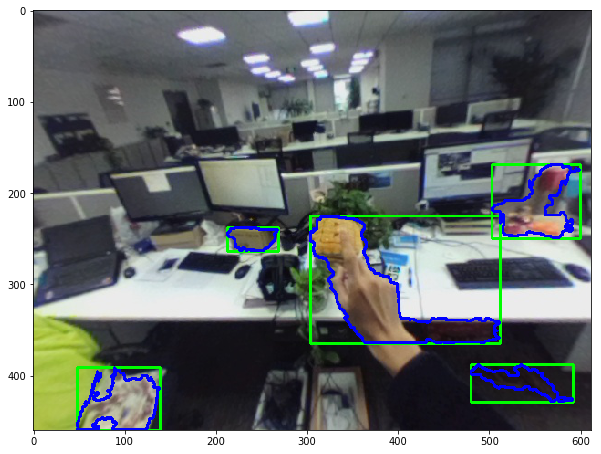

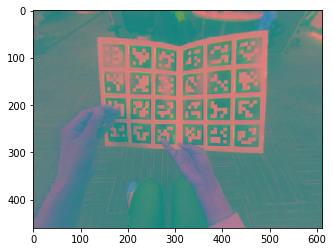

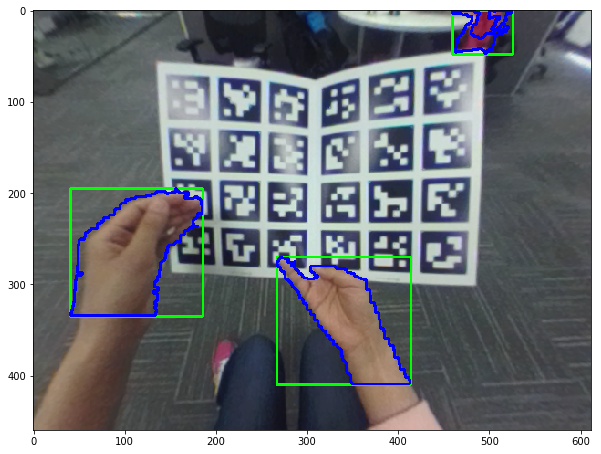

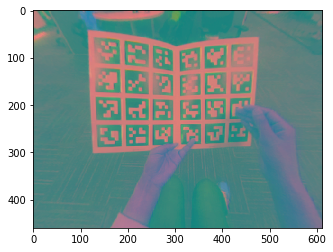

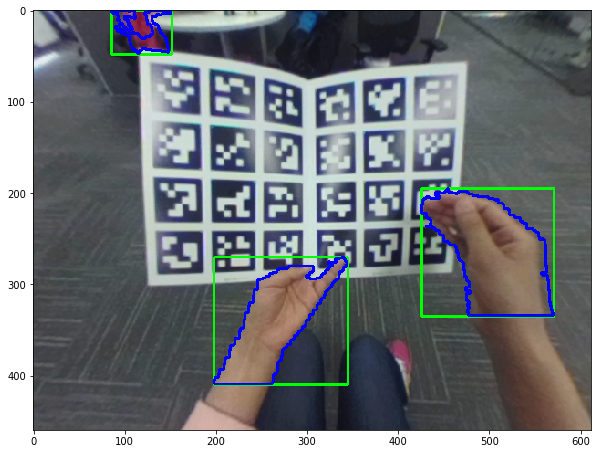

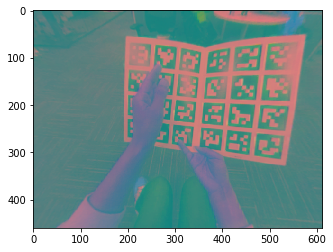

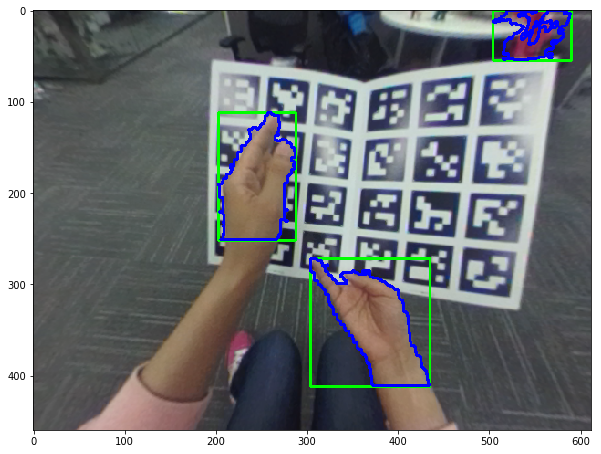

In [7]:
import judger_hand
test_files = judger_hand.get_file_names()
output_f = judger_hand.get_output_file_object()
for fname in test_files:
    img = imread(fname)
    bbox, img = find_hand_by_color(img)
    plt.imshow(img)
    plt.figure()
    print(bbox)

    #/data/image1.png 200 50 300 150 0 0.9
    for hand, box in bbox['bbox'].items():
        hand = 0 if hand == 'L' else 1
        output_f.write(('%s %d %d %d %d %d 0.0 \n' % (fname, box[0], box[1], box[2], box[3], hand)).encode())
            
judger_hand.judge()

In [ ]:
def IOU(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = (xB - xA + 1) * (yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

acc = 0
tot = 0
for i in range(0, len(images)+1):
    bbox, img_ = find_hand_by_color(images[i])
    print(labels[i])
    for hand, box in labels[i]['bbox'].items():
        tot += 1
        box_ = bbox['bbox'].get(hand)
        if box_ and IOU(box, box_) > 0.5:
            acc += 1
    bbox, _, _ = draw_bbox(img_, labels[i])
    #plt.figure(figsize=(10,10))
    #plt.imshow(bbox)
    
print(acc/tot)

[(30660, [227, 108, 219, 140]), (13464, [216, 324, 99, 136])]
{'bbox': {'R': [227, 108, 446, 248], 'L': [216, 324, 315, 460]}}
{'bbox': {'R': [219, 108, 393, 265], 'L': [218, 320, 313, 455]}}
[(28000, [368, 256, 200, 140]), (14560, [204, 320, 104, 140])]
{'bbox': {'R': [368, 256, 568, 396], 'L': [204, 320, 308, 460]}}
{'bbox': {'R': [357, 250, 513, 399], 'L': [213, 324, 296, 460]}}
[(30100, [192, 157, 215, 140]), (13938, [211, 322, 101, 138])]
{'bbox': {'R': [192, 157, 407, 297], 'L': [211, 322, 312, 460]}}
{'bbox': {'R': [185, 150, 347, 292], 'L': [218, 324, 311, 457]}}
[(27246, [197, 346, 239, 114]), (9877, [0, 93, 119, 83])]
{'bbox': {'R': [197, 346, 436, 460], 'L': [0, 93, 119, 176]}}
{'bbox': {'R': [270, 378, 448, 460], 'L': [200, 340, 277, 460]}}
[(28980, [206, 144, 207, 140]), (13365, [212, 325, 99, 135])]
{'bbox': {'R': [206, 144, 413, 284], 'L': [212, 325, 311, 460]}}
{'bbox': {'R': [194, 138, 361, 282], 'L': [218, 322, 308, 450]}}
[(20860, [359, 247, 149, 140]), (13125, [183,

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[(24220, [345, 148, 173, 140]), (14140, [203, 314, 101, 140])]
{'bbox': {'R': [345, 148, 518, 288], 'L': [203, 314, 304, 454]}}
{'bbox': {'R': [339, 141, 481, 291], 'L': [212, 315, 305, 459]}}
[(26600, [315, 202, 190, 140]), (14140, [203, 315, 101, 140])]
{'bbox': {'R': [315, 202, 505, 342], 'L': [203, 315, 304, 455]}}
{'bbox': {'R': [305, 192, 465, 355], 'L': [235, 317, 287, 451]}}
[(26740, [288, 154, 191, 140]), (14980, [207, 312, 107, 140])]
{'bbox': {'R': [288, 154, 479, 294], 'L': [207, 312, 314, 452]}}
{'bbox': {'R': [277, 147, 426, 288], 'L': [214, 313, 311, 453]}}
[(37520, [165, 176, 268, 140]), (6460, [13, 64, 76, 85])]
{'bbox': {'R': [165, 176, 433, 316], 'L': [13, 64, 89, 149]}}
{'bbox': {'R': [159, 169, 350, 322], 'L': [228, 328, 309, 447]}}
[(31080, [320, 229, 222, 140]), (15260, [204, 314, 109, 140])]
{'bbox': {'R': [320, 229, 542, 369], 'L': [204, 314, 313, 454]}}
{'bbox': {'R': [319, 223, 476, 369], 'L': [213, 311, 293, 455]}}
[(22540, [451, 222, 161, 140]), (14700, [19

[(28700, [74, 254, 205, 140]), (14141, [319, 381, 179, 79])]
{'bbox': {'L': [74, 254, 279, 394], 'R': [319, 381, 498, 460]}}
{'bbox': {'R': [323, 380, 410, 460], 'L': [109, 248, 279, 414]}}
[(26600, [77, 239, 190, 140]), (8480, [323, 380, 106, 80])]
{'bbox': {'L': [77, 239, 267, 379], 'R': [323, 380, 429, 460]}}
{'bbox': {'R': [313, 386, 419, 460], 'L': [82, 241, 272, 403]}}
[(31360, [23, 287, 224, 140]), (8208, [321, 384, 108, 76])]
{'bbox': {'L': [23, 287, 247, 427], 'R': [321, 384, 429, 460]}}
{'bbox': {'R': [317, 384, 415, 459], 'L': [83, 284, 255, 414]}}
[(28700, [62, 249, 205, 140]), (8400, [321, 376, 100, 84])]
{'bbox': {'L': [62, 249, 267, 389], 'R': [321, 376, 421, 460]}}
{'bbox': {'R': [317, 380, 419, 460], 'L': [107, 244, 274, 405]}}
[(27160, [77, 240, 194, 140]), (8480, [323, 380, 106, 80])]
{'bbox': {'L': [77, 240, 271, 380], 'R': [323, 380, 429, 460]}}
{'bbox': {'R': [326, 376, 412, 460], 'L': [102, 241, 269, 396]}}
[(26180, [71, 236, 187, 140]), (7372, [321, 384, 97, 76]

[(67200, [132, 0, 480, 140]), (2655, [12, 100, 59, 45])]
{'bbox': {'R': [132, 0, 612, 140], 'L': [12, 100, 71, 145]}}
{'bbox': {'R': [376, 205, 536, 412], 'L': [270, 359, 391, 458]}}
[(67340, [131, 0, 481, 140])]
{'bbox': {'R': [131, 0, 612, 140]}}
{'bbox': {'R': [388, 221, 565, 418], 'L': [273, 356, 390, 460]}}
[(27860, [275, 283, 199, 140]), (14840, [70, 130, 106, 140])]
{'bbox': {'R': [275, 283, 474, 423], 'L': [70, 130, 176, 270]}}
{'bbox': {'R': [288, 296, 426, 391], 'L': [76, 128, 170, 335]}}
[(22260, [300, 262, 159, 140]), (13860, [118, 133, 99, 140])]
{'bbox': {'R': [300, 262, 459, 402], 'L': [118, 133, 217, 273]}}
{'bbox': {'R': [311, 298, 430, 395], 'L': [119, 129, 210, 313]}}
[(25340, [272, 290, 181, 140]), (23660, [20, 149, 169, 140])]
{'bbox': {'R': [272, 290, 453, 430], 'L': [20, 149, 189, 289]}}
{'bbox': {'R': [282, 293, 391, 384], 'L': [19, 142, 190, 397]}}
[(24640, [291, 277, 176, 140]), (16100, [80, 90, 115, 140])]
{'bbox': {'R': [291, 277, 467, 417], 'L': [80, 90, 19

[(24500, [187, 179, 175, 140]), (4284, [518, 0, 63, 68])]
{'bbox': {'L': [187, 179, 362, 319], 'R': [518, 0, 581, 68]}}
{'bbox': {'R': [275, 296, 391, 396], 'L': [186, 168, 315, 370]}}
[(27440, [176, 193, 196, 140]), (4221, [519, 0, 63, 67])]
{'bbox': {'R': [519, 0, 582, 67]}}
{'bbox': {'R': [275, 300, 385, 387], 'L': [182, 188, 303, 368]}}
[(85680, [0, 0, 612, 140]), (6912, [303, 302, 108, 64])]
{'bbox': {'R': [303, 302, 411, 366]}}
{'bbox': {'R': [409, 223, 515, 395], 'L': [159, 290, 296, 402]}}
[(85680, [0, 0, 612, 140]), (9512, [252, 305, 164, 58])]
{'bbox': {'R': [252, 305, 416, 363]}}
{'bbox': {'R': [394, 138, 468, 301], 'L': [162, 299, 291, 405]}}
[(85680, [0, 0, 612, 140]), (6962, [290, 326, 118, 59])]
{'bbox': {'R': [290, 326, 408, 385]}}
{'bbox': {'R': [382, 148, 468, 309], 'L': [153, 323, 290, 433]}}
[(85680, [0, 0, 612, 140]), (5040, [232, 380, 72, 70])]
{'bbox': {'R': [0, 0, 612, 140], 'L': [232, 380, 304, 450]}}
{'bbox': {'R': [378, 169, 468, 324], 'L': [165, 326, 294, 43

[(85680, [0, 0, 612, 140]), (4959, [266, 108, 87, 57])]
{'bbox': {'R': [0, 0, 612, 140], 'L': [266, 108, 353, 165]}}
{'bbox': {'R': [230, 179, 347, 360], 'L': [191, 345, 317, 451]}}
[(85680, [0, 0, 612, 140]), (6210, [271, 162, 54, 115])]
{'bbox': {'R': [0, 0, 612, 140], 'L': [271, 162, 325, 277]}}
{'bbox': {'R': [357, 253, 463, 405], 'L': [187, 336, 315, 441]}}
[(85680, [0, 0, 612, 140]), (4845, [270, 110, 85, 57])]
{'bbox': {'R': [0, 0, 612, 140], 'L': [270, 110, 355, 167]}}
{'bbox': {'R': [328, 238, 437, 366], 'L': [197, 344, 316, 443]}}
[(85680, [0, 0, 612, 140]), (9639, [235, 141, 153, 63])]
{'bbox': {'R': [235, 141, 388, 204]}}
{'bbox': {'R': [351, 368, 461, 460], 'L': [209, 380, 330, 459]}}
[(85680, [0, 0, 612, 140]), (20720, [70, 138, 148, 140])]
{'bbox': {'R': [0, 0, 612, 140], 'L': [70, 138, 218, 278]}}
{'bbox': {'R': [378, 215, 481, 406], 'L': [218, 353, 346, 447]}}
[(85680, [0, 0, 612, 140]), (26460, [37, 82, 189, 140])]
{'bbox': {'R': [0, 0, 612, 140], 'L': [37, 82, 226, 2

[(26740, [52, 176, 191, 140]), (7007, [479, 366, 91, 77])]
{'bbox': {'L': [52, 176, 243, 316], 'R': [479, 366, 570, 443]}}
{'bbox': {'L': [63, 171, 184, 352]}}
[(20160, [0, 74, 144, 140]), (6552, [238, 256, 78, 84])]
{'bbox': {'L': [238, 256, 316, 340]}}
{'bbox': {'L': [4, 60, 148, 255]}}
[(20720, [101, 64, 148, 140]), (5852, [487, 160, 77, 76])]
{'bbox': {'L': [101, 64, 249, 204], 'R': [487, 160, 564, 236]}}
{'bbox': {'L': [110, 59, 244, 219]}}
[(16660, [121, 69, 119, 140]), (6450, [468, 161, 86, 75])]
{'bbox': {'L': [121, 69, 240, 209], 'R': [468, 161, 554, 236]}}
{'bbox': {'L': [121, 60, 243, 230]}}
[(15960, [130, 69, 114, 140]), (6141, [196, 288, 69, 89])]
{'bbox': {'L': [196, 288, 265, 377]}}
{'bbox': {'L': [117, 69, 255, 232]}}
[(20860, [164, 112, 149, 140]), (7980, [478, 238, 114, 70])]
{'bbox': {'L': [164, 112, 313, 252], 'R': [478, 238, 592, 308]}}
{'bbox': {'L': [168, 105, 317, 291]}}
[(24780, [209, 107, 177, 140]), (5256, [0, 218, 72, 73])]
{'bbox': {'R': [209, 107, 386, 247

[(28420, [174, 263, 203, 140]), (6630, [285, 16, 85, 78])]
{'bbox': {'R': [285, 16, 370, 94]}}
{'bbox': {'L': [260, 259, 383, 374]}}
[(23800, [109, 274, 170, 140]), (6794, [141, 310, 79, 86])]
{'bbox': {'L': [141, 310, 220, 396]}}
{'bbox': {'L': [140, 267, 284, 426]}}
[(25200, [109, 312, 180, 140]), (8712, [0, 126, 88, 99])]
{'bbox': {'L': [0, 126, 88, 225]}}
{'bbox': {'L': [164, 308, 290, 429]}}
[(23380, [116, 309, 167, 140]), (9400, [0, 133, 94, 100])]
{'bbox': {'L': [0, 133, 94, 233]}}
{'bbox': {'L': [164, 307, 285, 419]}}
[(29768, [137, 338, 244, 122]), (7000, [0, 157, 70, 100])]
{'bbox': {'R': [137, 338, 381, 460], 'L': [0, 157, 70, 257]}}
{'bbox': {'L': [220, 326, 386, 443]}}
[(26230, [136, 338, 215, 122]), (4560, [212, 20, 76, 60])]
{'bbox': {'L': [212, 20, 288, 80]}}
{'bbox': {'L': [211, 330, 355, 448]}}
[(18900, [208, 85, 135, 140]), (6975, [26, 193, 93, 75])]
{'bbox': {'L': [26, 193, 119, 268]}}
{'bbox': {'L': [201, 77, 345, 271]}}
[(27300, [136, 304, 195, 140]), (7695, [0, 1

[(42560, [308, 264, 304, 140]), (35581, [313, 0, 299, 119])]
{'bbox': {'R': [313, 0, 612, 119]}}
{'bbox': {'L': [258, 87, 381, 254]}}
[(43820, [299, 0, 313, 140]), (27020, [271, 154, 193, 140])]
{'bbox': {'R': [271, 154, 464, 294]}}
{'bbox': {'L': [329, 149, 464, 282]}}
[(46032, [276, 0, 336, 137]), (20952, [13, 185, 194, 108])]
{'bbox': {'R': [276, 0, 612, 137], 'L': [13, 185, 207, 293]}}
{'bbox': {'L': [278, 104, 433, 255]}}
[(25900, [162, 121, 185, 140]), (2405, [160, 23, 65, 37])]
{'bbox': {'L': [160, 23, 225, 60]}}
{'bbox': {'L': [167, 117, 233, 185]}}
[(45500, [287, 0, 325, 140]), (22960, [260, 124, 164, 140])]
{'bbox': {'R': [260, 124, 424, 264]}}
{'bbox': {'L': [287, 106, 439, 255]}}
[(38940, [282, 0, 330, 118]), (20580, [262, 108, 147, 140])]
{'bbox': {'R': [262, 108, 409, 248]}}
{'bbox': {'L': [279, 97, 419, 250]}}
[(35392, [296, 0, 316, 112]), (30380, [239, 146, 217, 140])]
{'bbox': {'R': [239, 146, 456, 286]}}
{'bbox': {'L': [287, 140, 409, 238]}}
[(53200, [232, 181, 380, 1

In [189]:
hands = left_hands + right_hands
hands_ycbcr = [cv2.cvtColor(hand, cv2.COLOR_BGR2YCR_CB) for hand in hands]

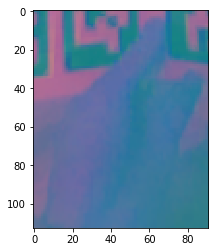

In [191]:
plt.imshow(hands_ycbcr[100])

In [259]:
img = hands_ycbcr[100].reshape((-1, 3))
print(np.min(img, axis=0))
print(np.max(img, axis=0))

[ 13  99 131]
[186 137 171]


In [241]:
import numpy, logging

logger = logging.getLogger('main')


def get_hsv_mask(img, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug('getting hsv mask')

    lower_thresh = numpy.array([0, 50, 0], dtype=numpy.uint8)
    upper_thresh = numpy.array([120, 150, 255], dtype=numpy.uint8)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    msk_hsv = cv2.inRange(img_hsv, lower_thresh, upper_thresh)

    msk_hsv[msk_hsv < 128] = 0
    msk_hsv[msk_hsv >= 128] = 1

    if debug:
        scripts.display('input', img)
        scripts.display('mask_hsv', msk_hsv)

    return msk_hsv.astype(float)


def get_rgb_mask(img, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug('getting rgb mask')

    lower_thresh = numpy.array([45, 52, 108], dtype=numpy.uint8)
    upper_thresh = numpy.array([255, 255, 255], dtype=numpy.uint8)

    mask_a = cv2.inRange(img, lower_thresh, upper_thresh)
    mask_b = 255 * ((img[:, :, 2] - img[:, :, 1]) / 20)
    mask_c = 255 * ((numpy.max(img, axis=2) - numpy.min(img, axis=2)) / 20)
    # msk_rgb = cv2.bitwise_and(mask_c, cv2.bitwise_and(mask_a, mask_b))
    mask_d = numpy.bitwise_and(numpy.uint64(mask_a), numpy.uint64(mask_b))
    msk_rgb = numpy.bitwise_and(numpy.uint64(mask_c), numpy.uint64(mask_d))

    msk_rgb[msk_rgb < 128] = 0
    msk_rgb[msk_rgb >= 128] = 1

    if debug:
        scripts.display('input', img)
        scripts.display('mask_rgb', msk_rgb)

    return msk_rgb.astype(float)


def get_ycrcb_mask(img, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug('getting ycrcb mask')

    lower_thresh = numpy.array([90, 100, 130], dtype=numpy.uint8)
    upper_thresh = numpy.array([230, 120, 180], dtype=numpy.uint8)

    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    msk_ycrcb = cv2.inRange(img_ycrcb, lower_thresh, upper_thresh)

    msk_ycrcb[msk_ycrcb < 128] = 0
    msk_ycrcb[msk_ycrcb >= 128] = 1

    if debug:
        scripts.display('input', img)
        scripts.display('mask_ycrcb', msk_ycrcb)

    return msk_ycrcb.astype(float)


def grab_cut_mask(img_col, mask, debug=False):
    assert isinstance(img_col, numpy.ndarray), 'image must be a numpy array'
    assert isinstance(mask, numpy.ndarray), 'mask must be a numpy array'
    assert img_col.ndim == 3, 'skin detection can only work on color images'
    assert mask.ndim == 2, 'mask must be 2D'

    kernel = numpy.ones((50, 50), numpy.float32) / (50 * 50)
    dst = cv2.filter2D(mask, -1, kernel)
    dst[dst != 0] = 255
    free = numpy.array(cv2.bitwise_not(dst), dtype=numpy.uint8)

    if debug:
        scripts.display('not skin', free)
        scripts.display('grabcut input', mask)

    grab_mask = numpy.zeros(mask.shape, dtype=numpy.uint8)
    grab_mask[:, :] = 2
    grab_mask[mask == 255] = 1
    grab_mask[free == 255] = 0

    if numpy.unique(grab_mask).tolist() == [0, 1]:
        logger.debug('conducting grabcut')
        bgdModel = numpy.zeros((1, 65), numpy.float64)
        fgdModel = numpy.zeros((1, 65), numpy.float64)

        if img_col.size != 0:
            mask, bgdModel, fgdModel = cv2.grabCut(img_col, grab_mask, None, bgdModel, fgdModel, 5,
                                                   cv2.GC_INIT_WITH_MASK)
            mask = numpy.where((mask == 2) | (mask == 0), 0, 1).astype(numpy.uint8)
        else:
            logger.warning('img_col is empty')

    return mask


def closing(mask):
    assert isinstance(mask, numpy.ndarray), 'mask must be a numpy array'
    assert mask.ndim == 2, 'mask must be a greyscale image'
    logger.debug("closing mask of shape {0}".format(mask.shape))

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    return mask


def process(img, thresh=0.5, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug("processing image of shape {0}".format(img.shape))

    mask_hsv = get_hsv_mask(img, debug=debug)
    mask_rgb = get_rgb_mask(img, debug=debug)
    mask_ycrcb = get_ycrcb_mask(img, debug=debug)

    n_masks = 3.0
    mask = (mask_hsv + mask_rgb + mask_ycrcb) / n_masks

    mask[mask < thresh] = 0.0
    mask[mask >= thresh] = 255.0
    logger.debug('{0}% of the image is skin'.format(int((100.0 / 255.0) * numpy.sum(mask) / mask.size)))

    mask = mask.astype(numpy.uint8)

    mask = closing(mask)
    mask = grab_cut_mask(img, mask, debug=debug)

    return mask

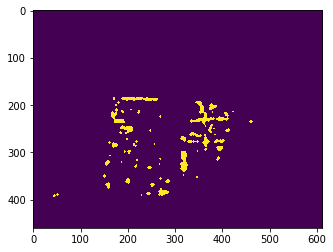

In [249]:
plt.imshow(process(images[100], 0.35))